In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS
import clustering as clstr
import bout as bt
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt

from cli import get_file_paths

In [4]:
site_key = 'Central'
freq_key = 'HF2'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000
print(f'Looking at {fig_details["site_name"]}')

Looking at Central Pond


/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_35854/3485040633.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)


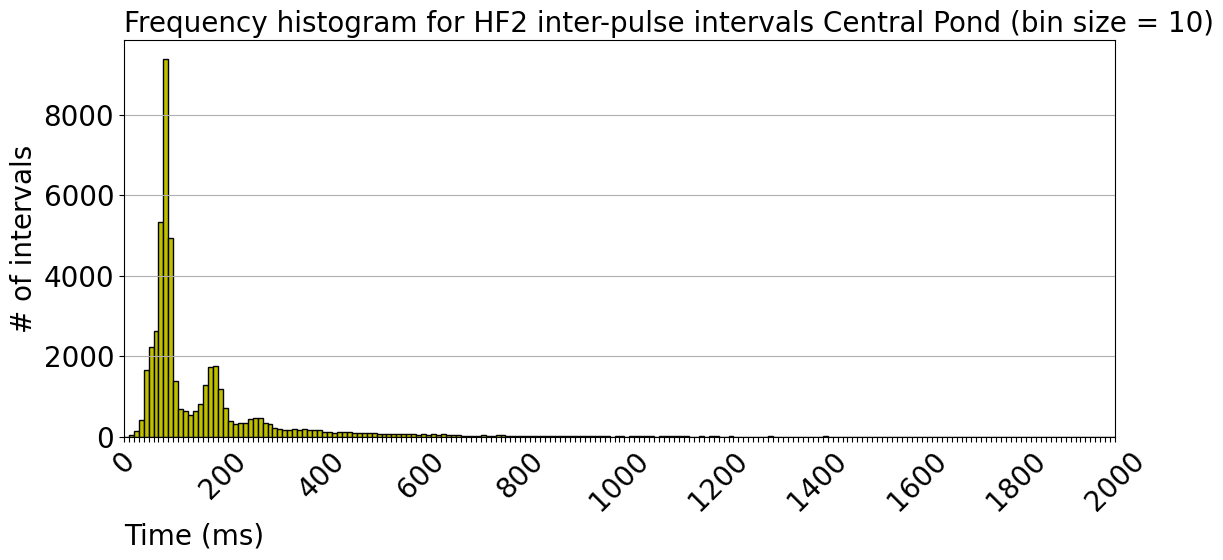

In [5]:
location_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)
ipis_f, hist_f = bt_plt.plot_ipi_hist(location_df, fig_details)

In [6]:
location_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_35854/526168442.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)


Fagen&Young method has 1666392927 missassigned points
Slater method has 612613 missassigned points
Sibly method has 588398 missassigned points
Optim BCI has less misassignments than BCI? True
24214 more points assigned correctly


In [7]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.005116777544899781, intercept=10.819623518201936, rvalue=-0.9682507901233154, pvalue=4.318106459757727e-25, stderr=0.00021153539738622337, intercept_stderr=0.049156384272612666),
  'indices': range(0, 41),
  'lambda': 0.005116777544899781,
  'num_intervals_slater': 9770262.99261275},
 {'metrics': LinregressResult(slope=-3.4404455348516634e-07, intercept=6.351432531518606, rvalue=-0.9852526840639382, pvalue=0.0, stderr=4.4842626946003965e-11, intercept_stderr=0.0004619653959053101),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 3.4404455348516634e-07,
  'num_intervals_slater': 1666392927.183173})

In [8]:
nlin_results

{'solution': array([9.40479447e+06, 5.33000713e-03, 1.66639302e+09, 3.44044560e-07]),
 'fast_num_intervals': 9404794.47187764,
 'fast_lambda': 0.005330007126537745,
 'slow_num_intervals': 1666393019.7311134,
 'slow_lambda': 3.440445596771488e-07,
 'bci': 838.8700729936862}

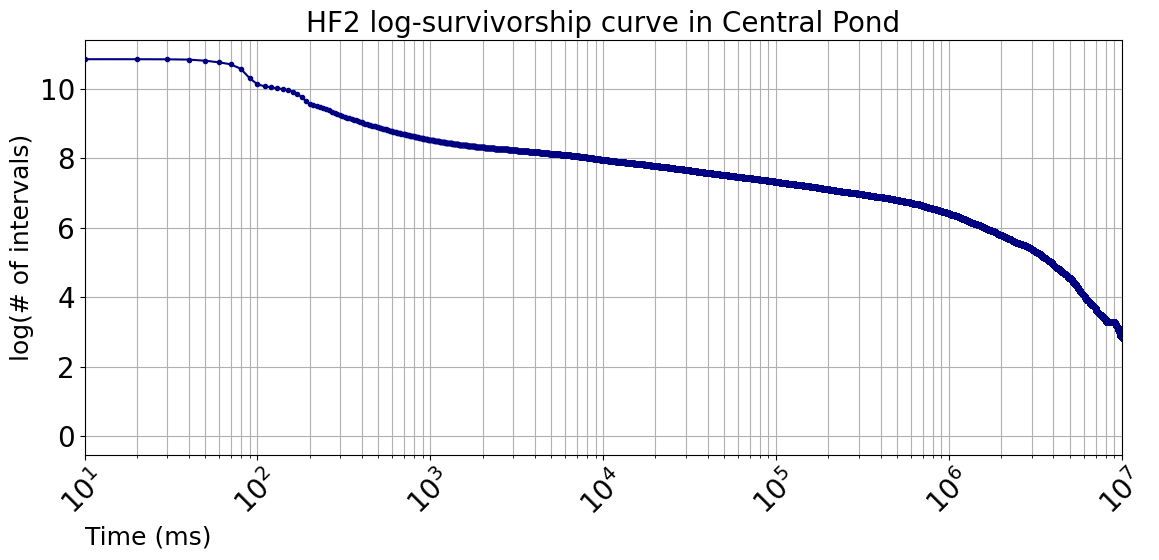

In [9]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)

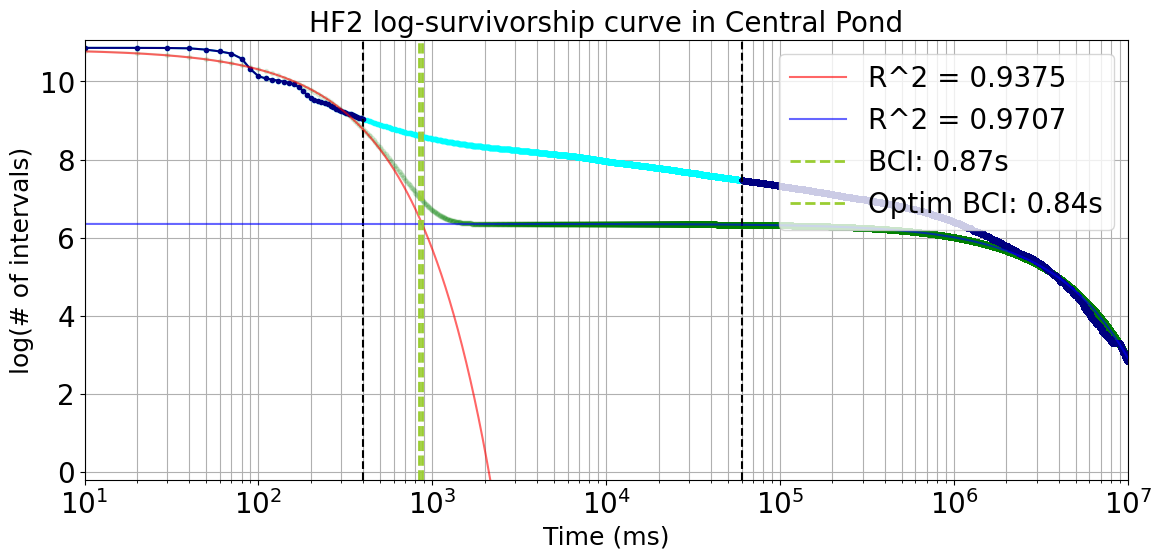

In [10]:
fig_details['time_end'] = 60000
fig_details['site_name'] = SITE_NAMES[site_key]
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

Fagen&Young method has 1098353423 missassigned points
Slater method has 199874 missassigned points
Sibly method has 182026 missassigned points
Optim BCI has less misassignments than BCI? True
17847 more points assigned correctly


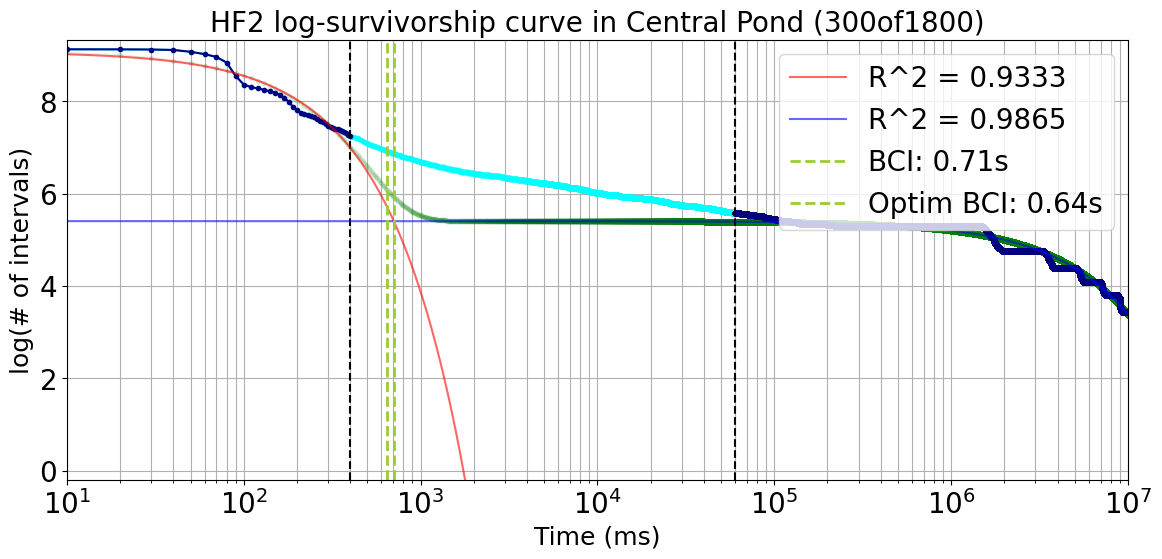

In [11]:
data_params = dict()
data_params['type_tag'] = freq_key
data_params['site_tag'] = site_key
data_params['cur_dc_tag'] = '300of1800'
fig_details['site_name'] = SITE_NAMES[site_key] + ' ' + f"({data_params['cur_dc_tag']})"

file_paths = get_file_paths(data_params)

location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, data_params['cur_dc_tag'])
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

Fagen&Young method has 1200300595 missassigned points
Slater method has 159980 missassigned points
Sibly method has 147142 missassigned points
Optim BCI has less misassignments than BCI? True
12837 more points assigned correctly


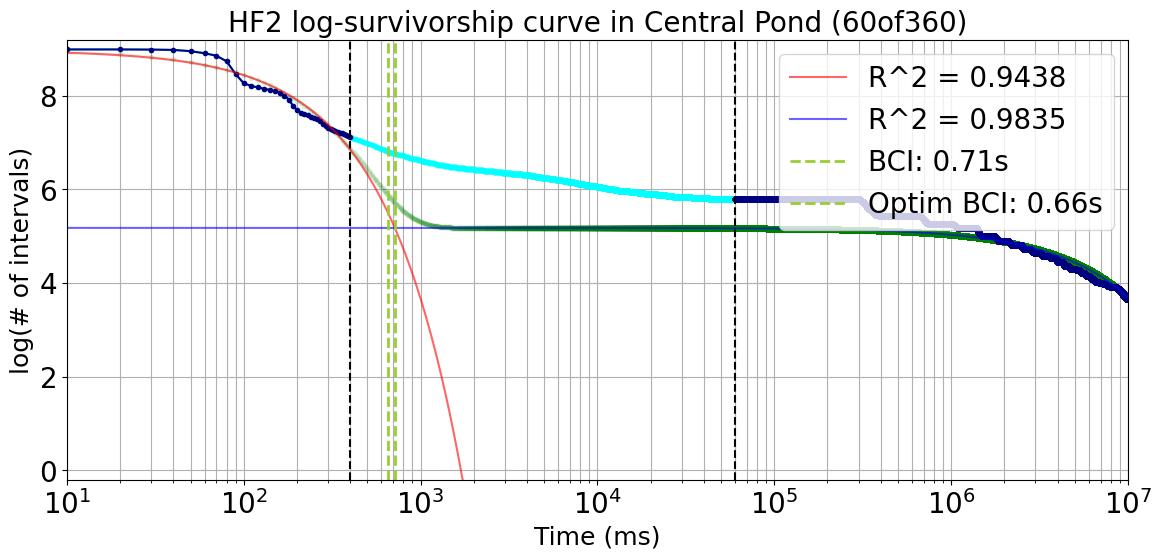

In [12]:
data_params = dict()
data_params['type_tag'] = freq_key
data_params['site_tag'] = site_key
data_params['cur_dc_tag'] = '60of360'
fig_details['site_name'] = SITE_NAMES[site_key] + ' ' + f"({data_params['cur_dc_tag']})"

file_paths = get_file_paths(data_params)

location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, data_params['cur_dc_tag'])
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

In [13]:
filepath_key = EXAMPLE_FILES_from_LOCATIONS[bout_params['site_key']][5]
filename = filepath_key.split('/')[-1]

file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

data_params = dict()
data_params['site_tag'] = bout_params['site_key']
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'

file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
bout_params = bt.get_bout_params_from_location(actvt.assemble_initial_location_summary(data_params, file_paths), data_params)
batdetect2_preds_with_bouttags = bt.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

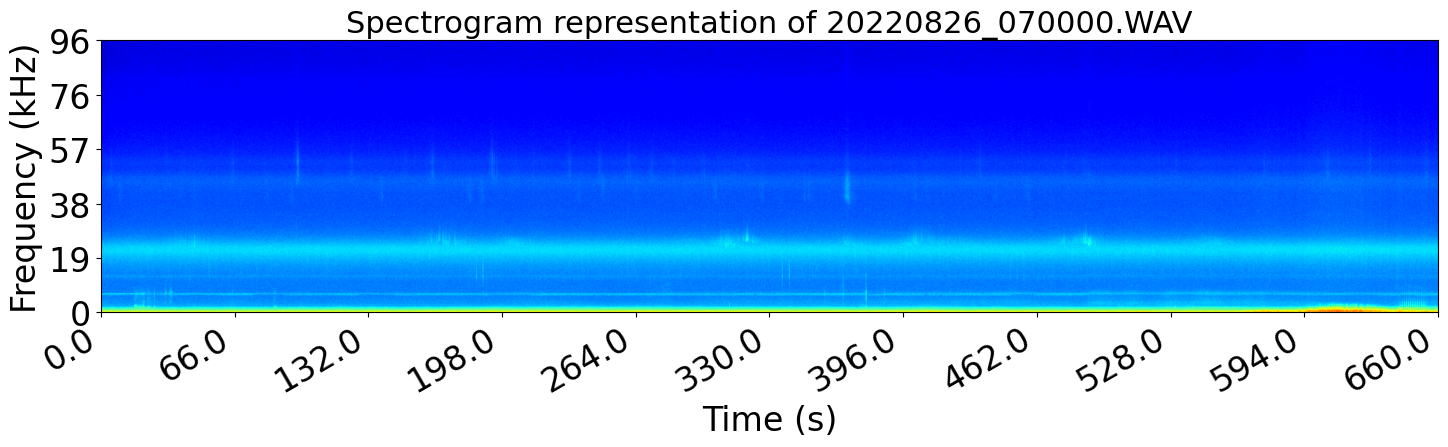

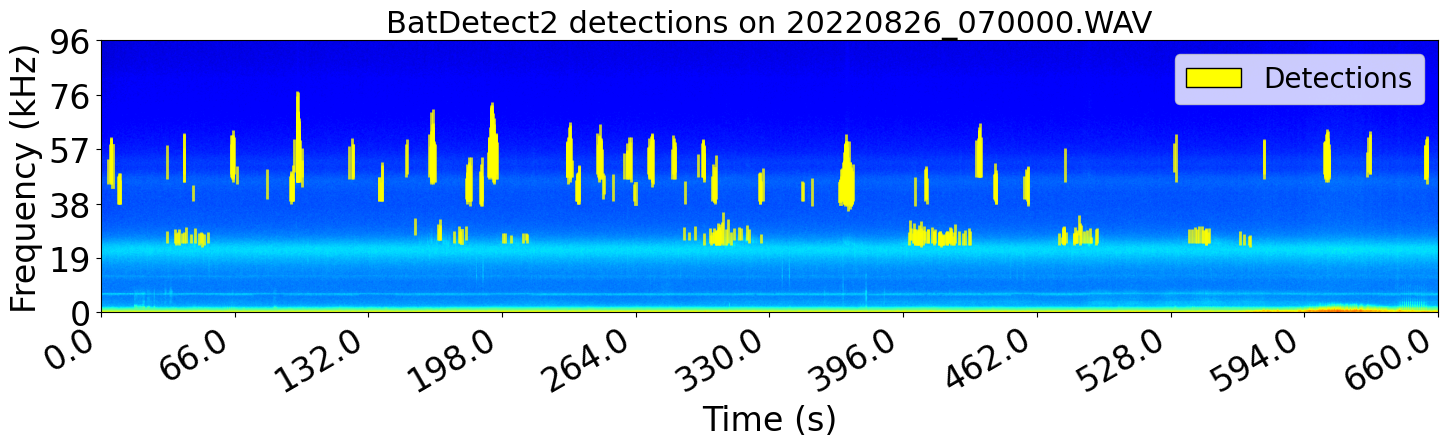

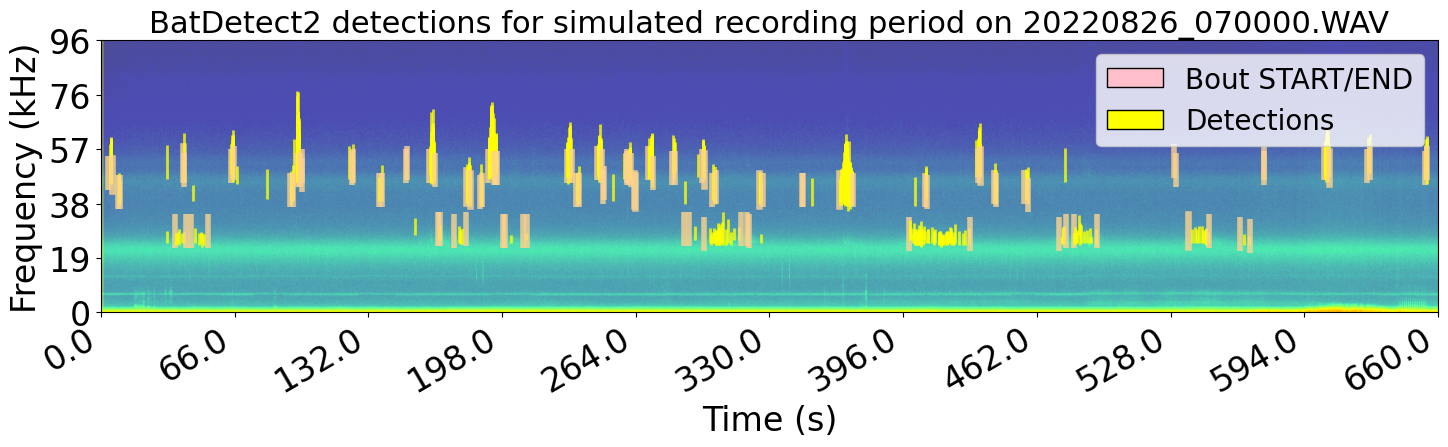

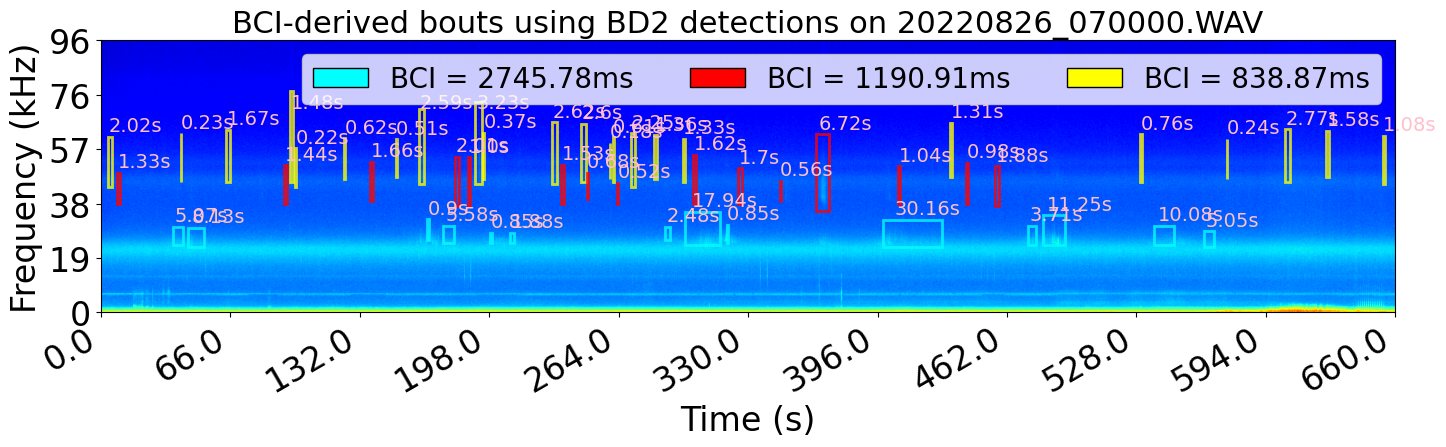

In [14]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [15]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 600
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

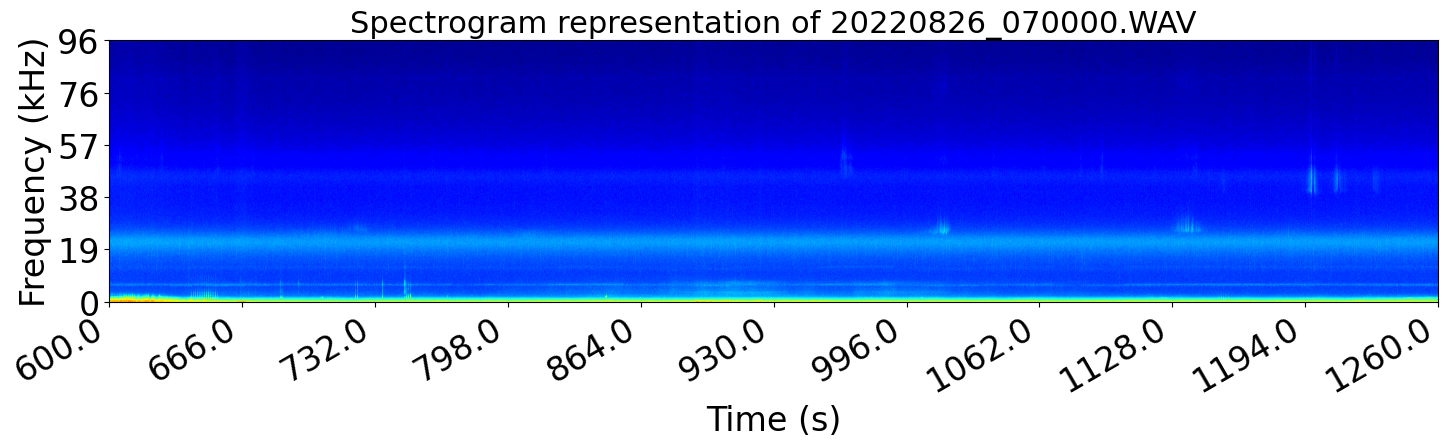

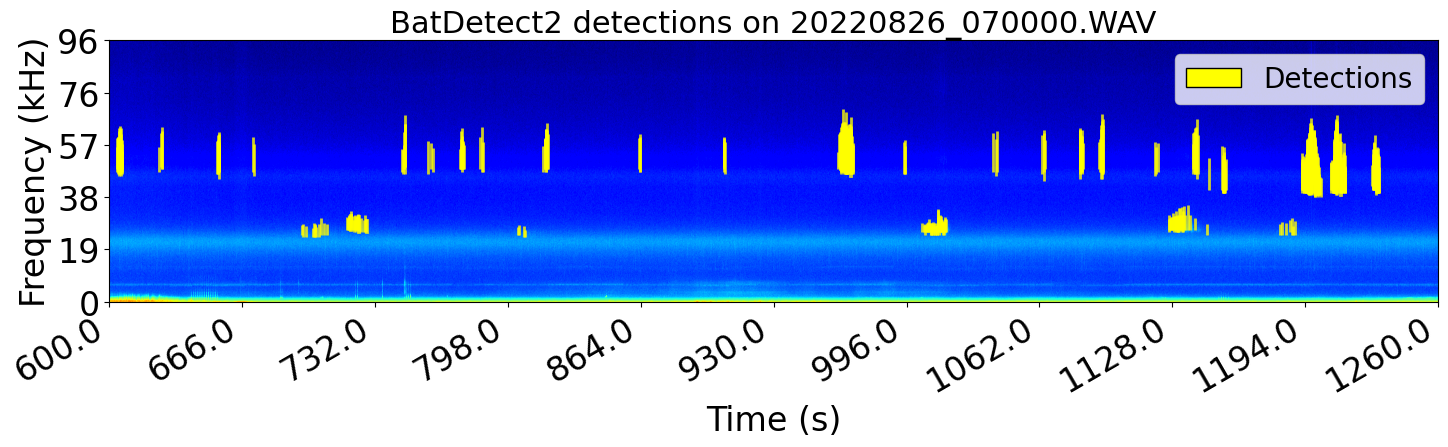

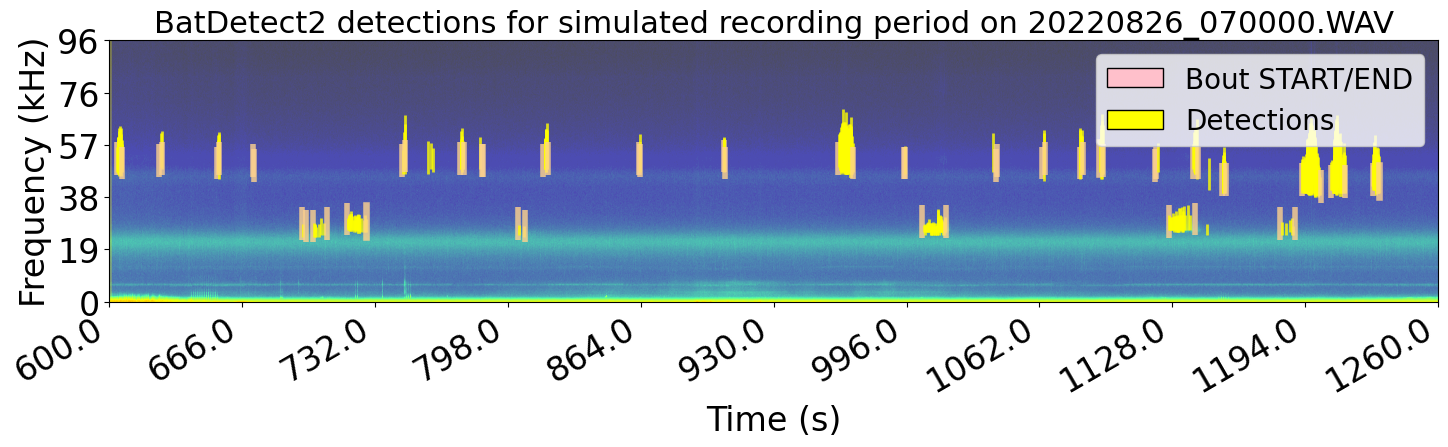

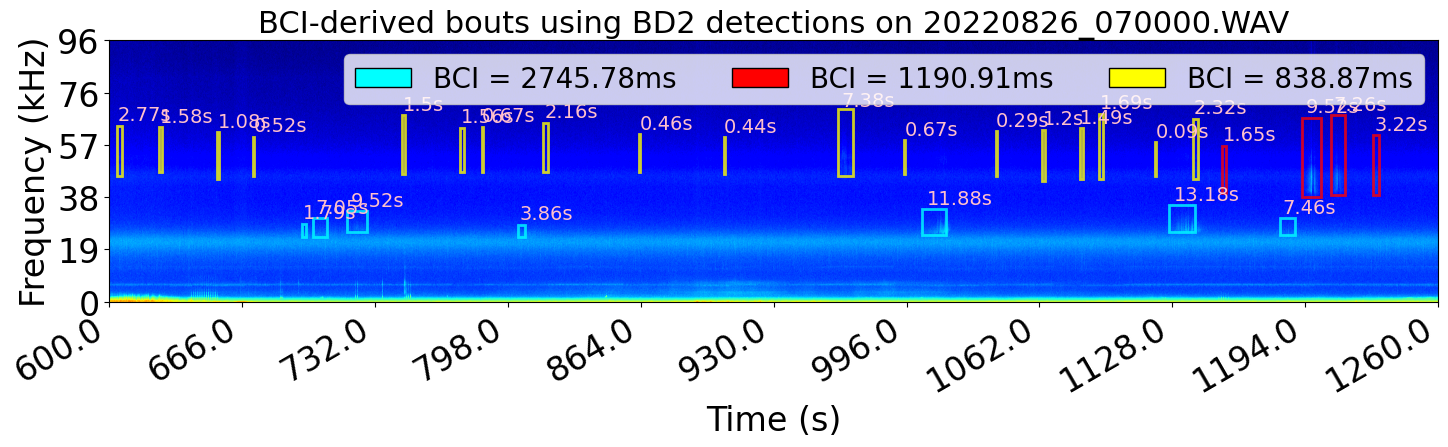

In [16]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [17]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 1200
duration = 600
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 55 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

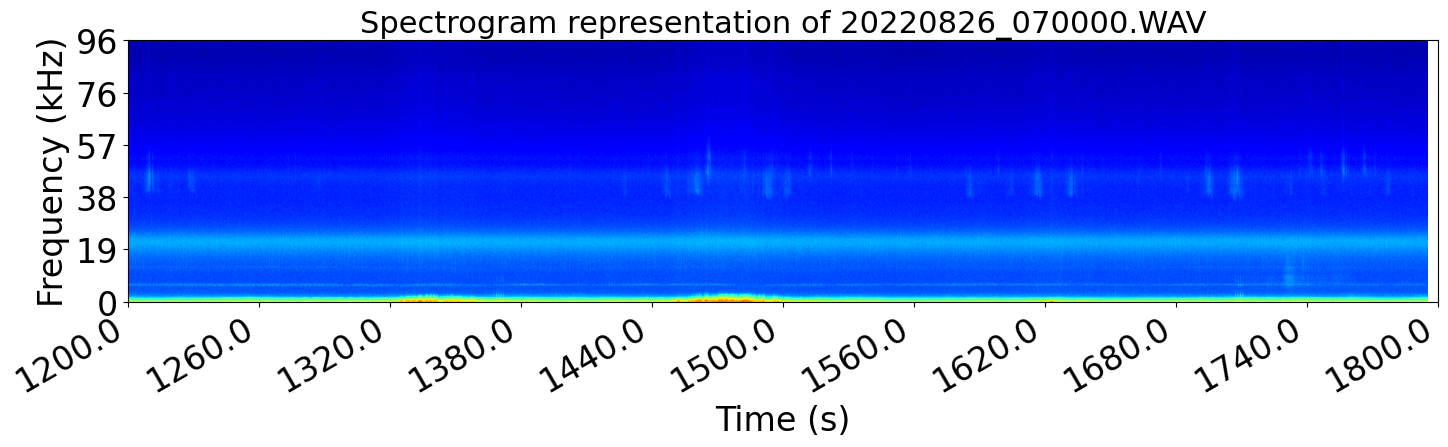

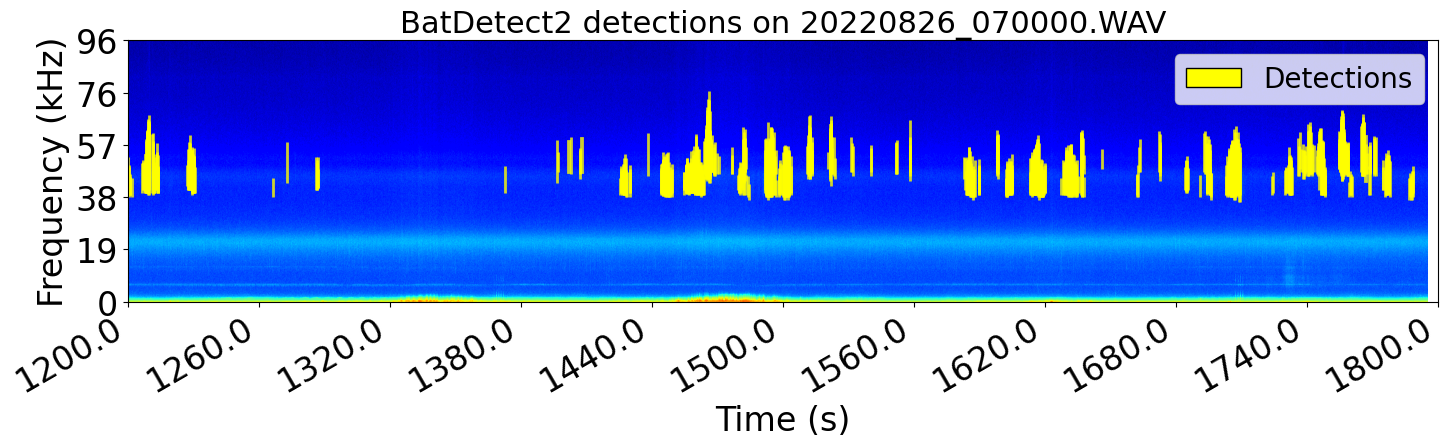

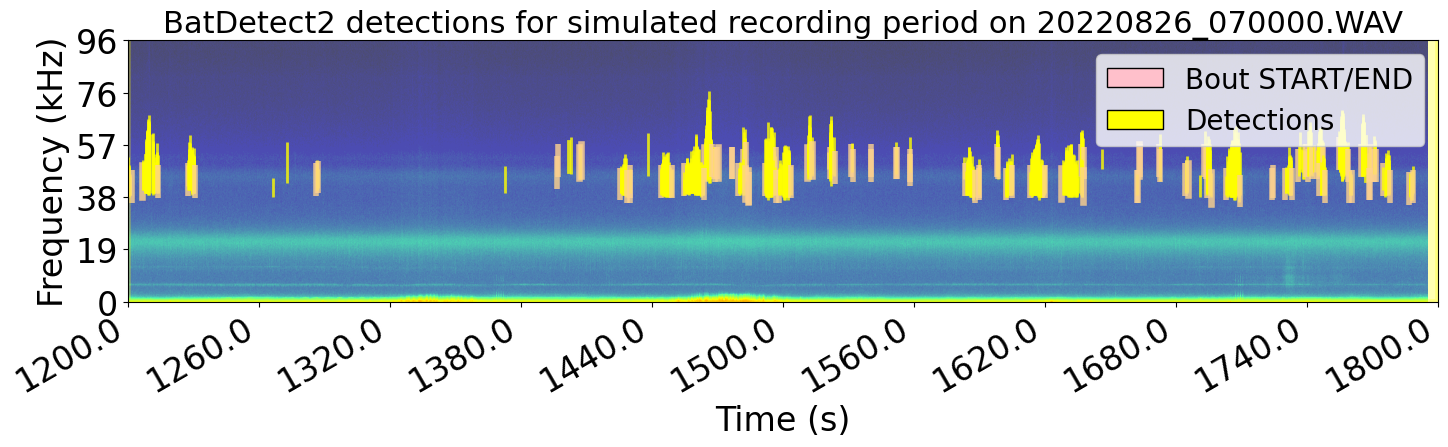

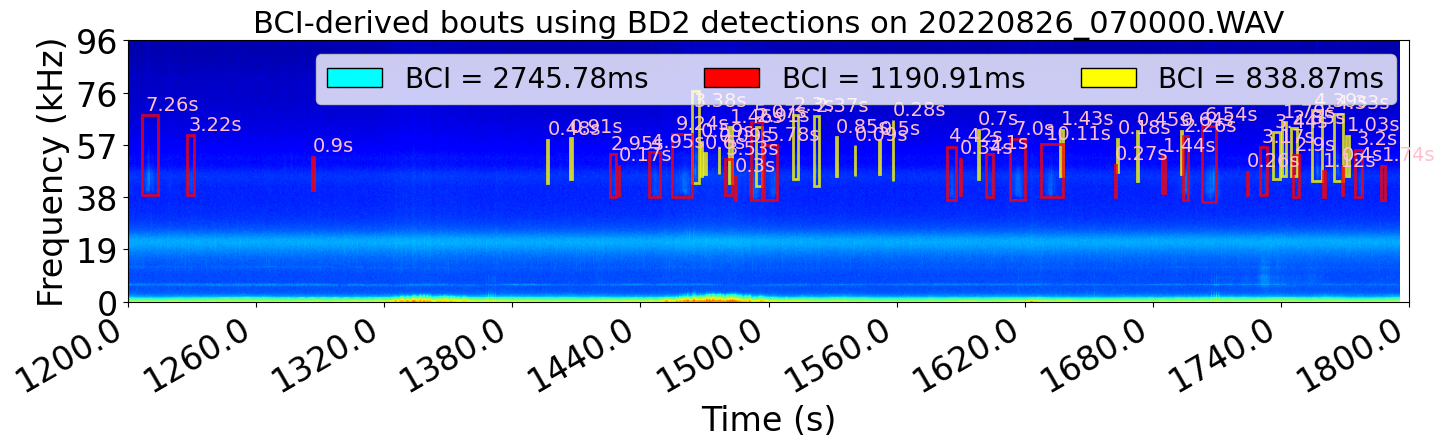

In [18]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)